In [1]:
import os
import time
import json
from typing import TypedDict, Annotated, Any, Union, Optional, List, Dict, Sequence
import operator

# 基础组件
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# 特殊组件
# 使用 lc_tool 装饰器包装完后的函数的类型是: langchain_core.tools.base.BaseTool 的子类:
# langchain_core.tools.structured.StructuredTool
from langchain_core.tools import tool as lc_tool
# v1.x 版本将被替换为: from langchain.agents.tool_node import ToolNode
from langgraph.prebuilt import ToolNode

from langgraph.graph import add_messages

# 高级接口
from langchain.agents import create_agent
# v0.x 版本用法: from langgraph.prebuilt import create_react_agent


from dotenv import load_dotenv
load_dotenv()

True

前置知识
- python 基本使用
- 大模型的基本使用
- Dify 式平台的使用

无需的前置知识
- OpenAI SDK
- LangChain

# Part 1 (LangGraph 基础)

In [14]:
provider = "WILDCARD"
model = "gpt-5-mini"
base_url = os.environ[f"{provider}_BASE_URL"]
api_key = os.environ[f"{provider}_API_KEY"]

print(f"provider: {provider}\nmodel: {model}\nbase_url: {base_url}")

model = ChatOpenAI(model=model, base_url=base_url, api_key=api_key)

provider: WILDCARD
model: gpt-5-mini
base_url: https://api.gptsapi.net/v1


## 1.1 示例 

TODO: 一个实际项目的例子

基本概念:
- State
- Node
- Edge
- Conditional Edge
- Graph

## 1.2 State

**State**, Node, Edge, Conditional Edge, Graph

注意: state 定义里, TypedDict 必须要加上, 不能是普通的类

In [29]:
class Info(TypedDict):
    name: str
    phone: str
    address: str

info = Info(name="foo", phone="12345678", address="ShenZhen")

In [ ]:
# TypeDict 不是继承, 而是类型注解, 实例化后的 info 实际上是普通的字典
# TypeDict 除了是 langgraph 的要求以外, 其本身的好处是: 在编程 IDE 下进行智能提醒
info.__class__

dict

In [ ]:
def foo() -> Info:
    return Info(name="foo", phone="12345678", address="ShenZhen")
foo()["address"]

## 1.3 Node

State, **Node**, Edge, Conditional Edge, Graph

- langchain Runnable: invoke/ainvoke, stream/astream
- function: 本质上也是转化为 RunnableLambda

注意: 函数的输入是 State 类型的字典, 输出是字典, 注意输出字段可以不包含 State 的全部字段, state 相当于是全局变量, 每个函数都可以从里面取值, 然后用 node 返回的值来更新 state 这个全局变量

### 1.3.1 LangChain 简介 (Runnable)

LangChain 的核心是 Runnable, 包含 invoke/ainvoke, stream/astream 方法, 通过

chain = runnable1 | runnable2 | runnable3

这种方式将流程串联起来: 先执行 runnable1, 再执行 runnable2, 再执行 runnable3.

(1) LangChain 内置了许多基础的 Runnable, 以下所有的类都是 Runnable 的子类: 

- ChatPromptTemplate: prompt 模板, 类似于 f-string 的作用
- BaseChatModel: 大模型
- OutputParser: 对大模型输出字段结构化解析, 例如 json, xml 等
- tool: 工具使用
- retriever: 文档检索
- ...

(2) 可组合的 Runnable（Composable Runnables）

LangChain 提供了一组底层的可组合组件, 用来以声明式的方式组织复杂的调用逻辑:

- RunnableLambda：把一个普通的 Python 函数包装成 Runnable, 可与其他 Runnable 串联使用
- RunnableSequence：顺序执行多个 Runnables，上一个的输出作为下一个的输入, 例如: chain = runnable1 | runnable2
- RunnableBinding：绑定参数或配置到某个 Runnable 上 (例如原本的 runnable 需要入参 a 和 b, 可以通过 bind 方法绑定 a=1, 后续用的时候只需要传递参数 b 即可), 类似于偏函数 partial-function
- RunnableParallel / RunnableMap：并行运行多个 Runnables, 各自独立执行
- RunnableBranch：根据输入条件执行不同的 Runnable 分支, 类似于 if/else

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一个信息抽取助手。请从输入文本中提取出省份、城市、姓名和电话号码。"),
    ("human", "文本内容如下：{input_text}\n\n请以JSON格式返回。key 为 province, city, name, phone"),
])

parser = JsonOutputParser()
chain = prompt | model | parser
# chain 其实是 RunnableSequence

# |: 在 shell 命令里被称为管道运算符, 表示把上一个的输入当作下一个的输出
# 例子:  `ls | grep ".py" | wc -l` 查看当前文件夹下 python 文件的数量

# 在 python 中, | 实际上是 __or__ 和 __ror__ 这个特殊方法, Runnable 重载了这两个特殊方法
# 因此实际上是  (prompt.__or__(model)).__or__(parser)

input_text = "您好，我是张三，电话是13800138000，住在广东省深圳市南山区。"

result = chain.invoke({"input_text": input_text})

In [23]:
result

{'province': '广东省', 'city': '深圳市', 'name': '张三', 'phone': '13800138000'}

In [24]:
# 可以只运行一部分看下中间的输出, 尤其是 debug 时可以关注输出的数据结构
# langsmith 也可以看的很清楚
(prompt | model).invoke({"input_text": input_text})

AIMessage(content='{"province":"广东省","city":"深圳市","name":"张三","phone":"13800138000"}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 225, 'prompt_tokens': 76, 'total_tokens': 301, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CQm88lvRPULx0rerRn32nHzONtjGx', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--bde3e7d3-e8d6-4efe-bbe1-9bd0abbff8ad-0', usage_metadata={'input_tokens': 76, 'output_tokens': 225, 'total_tokens': 301, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}})

In [ ]:
def my_json_output_parser(input: BaseMessage):
    output = {
        "province": "",
        "city": "",
        "name": "",
        "phone": ""
    }
    try:
        parsed_output = json.loads(input.content)
        for key in output.keys():
            output[key] = parsed_output[key]
    except:
        pass
    return output

# 可以直接串接函数, 会自动转为 RunnableLambda
chain = prompt | model | my_json_output_parser

chain.invoke({"input_text": input_text})

{'province': '广东省', 'city': '深圳市', 'name': '张三', 'phone': '13800138000'}

In [ ]:
# 顺带一提: 可以用 PydanticOutputParser 来验证大模型输出的数据结构
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

class Info(BaseModel):
    province: str = Field(..., description="省份名称", default="")
    city: str = Field(..., description="城市名称", default="")
    name: str = Field(..., description="人的姓名", default="")
    phone: str = Field(..., description="电话号码", default="")


parser = PydanticOutputParser(pydantic_object=Info)
chain = prompt | model | parser
chain.invoke({"input_text": input_text})

In [ ]:
# 顺带一提: langchain 自带的 JsonOutputParser 可以做流式效果
chain = prompt | model | JsonOutputParser()

for current_data in chain.stream({"input_text": input_text}):
    print(current_data)

{}
{'province': ''}
{'province': '广东'}
{'province': '广东省'}
{'province': '广东省', 'city': ''}
{'province': '广东省', 'city': '深圳'}
{'province': '广东省', 'city': '深圳市'}
{'province': '广东省', 'city': '深圳市南'}
{'province': '广东省', 'city': '深圳市南山区'}
{'province': '广东省', 'city': '深圳市南山区', 'name': ''}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张'}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三'}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三', 'phone': ''}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三', 'phone': '138'}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三', 'phone': '138001'}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三', 'phone': '138001380'}
{'province': '广东省', 'city': '深圳市南山区', 'name': '张三', 'phone': '13800138000'}


## 1.4 Edge, Conditional Edge, Graph

State, Node, **Edge, Conditional Edge, Graph**

例子: [examples/write_essay/graph.py](examples/write_essay/graph.py)

备注:

- draw_mermaid 方法可以作图 (1.1示例已经展示过)
- conditional edge

Tips:

(1) 在函数内部对 state 做 in-place 的修改不会生效

(2) END 节点可以是隐式的, 可以不显式连边到 END

In [ ]:
class State(TypedDict):
    xs: list[str]

def add_xs(state):
    if not state.get("xs"):
        state["xs"] = []
    state["xs"].append(1)
    return {}

builder = StateGraph(State)
builder.add_node("add_xs", add_xs)
builder.add_edge(START, "add_xs")
state = builder.compile().invoke({})

## 1.5 对比拖拉拽

总体来说, langgraph 和 Dify 平台的基本执行逻辑还是类似的:

- Dify 中的变量  相当于  langgraph 的 State
- Dify 中的节点  相当于  langgraph 的 node (大部分 Dify 平台的节点, 本质上都可以函数代替)
- Dify 的连线  相当于  langgraph 的 edge
- Dify 的if分支  相当于  langgraph 的 conditional edge

Dify 目前像 知识库检索, 大模型调用 这些功能只能单独拉一个节点来做, 但 langgraph 可以灵活处理, 可以把几个处理步骤合并在一个节点里. 例如: 在 Dify 平台里

- 将几个字段拼接好: 一个函数节点  (可能产生一个临时字段 llm_input)
- 将拼接好的字段给大模型: 大模型节点  (可能产生一个临时字段 llm_output)
- 对大模型节点输出解析: 一个函数节点

上面 3 个步骤, 在 langgraph 可以直接做合并, 在逻辑上其实也是清晰的, 而且可能还省了些临时变量, 无需在 State 里声明.

# Part 2: LangGraph 特性

- langsmith 集成
- langgraph-cli, langgraph studio, langgraph-sdk
- 流式: 支持 state 的变化, token 输出, 自定义流式输出内容
- checkpoint+时光机

## 2.1 langsmith 集成

运行 [examples/chatbot/chatbot1.py](examples/chatbot/chatbot1.py), 观察 langsmith 的输出

langsmith 本质原理和 OpenTelemetry 比较类似, 【这里可能贴一下官方解释的那张图】

```python
# 将 fn 想象成 graph.invoke/stream
# 创建一个 trace_id, 对于根节点, 也是 run_id
def fn():
    # ...
    # 将这里的 fn1, fn2 想象为一个 Runnable
    # langchain 中自带的 Runnable, 例如 ChatModel, OutputParser, PromptTemplate
    # 打开环境变量 在调用 invoke, stream 方法时, 会将入参,中间结果,返参通过接口发送给 langsmith 服务器:
    # 创建 Run (span): parent_run_ids = [fn.run_id]
    fn1()
    # ...
    fn2()
```

这样一来, langsmith 就可以展示出各个调用的层级关系

注意: langsmith 本身的服务端代码是闭源的, 因此这本身算是 LangChain 公司一个盈利模块, 免费套餐一个月可以有 5000 个 trace_id.

注意: 由于数据需要发往 langsmith, 所以不适用于私有化部署的场景. (1) langchain 生态也支持 OpenTelemetry, 而 OpenTelemetry 规范下有一些可本地化部署的 Backend, 例如: Jaeger Backend, 因此可以考虑本地化部署 OpenTelemetry, 以支持私有化场景; (2) 另外, 也有一些三方集成, 例如: Arize Phoenix 可以本地化部署, 做到类似于 langsmith 的效果

另外, 其实使用 langsmith 适用于做 langchain 无关埋点分析, langsmith 也提供了相应的易用工具(此处从略)

## 2.2 langgraph cli, langgraph studio, langgraph sdk

- langgraph cli: 创建 langgraph 项目模板, 并将 StateGraph 部署为服务
- langgraph studio: 专门为 langgraph 做的 Web 前端, 可以对 langgraph 地执行过程进行交互式地调试观察
- langgraph sdk: 调用 langgraph cli 部署的服务(本质上应该是 http 调用)


```bash
langgraph new playground/demo --template new-langgraph-project-python

# Output:
# 📥 Attempting to download repository as a ZIP archive...
# URL: https://github.com/langchain-ai/new-langgraph-project/archive/refs/heads/main.zip
# ✅ Downloaded and extracted repository to /home/buxian/Desktop/lg_tutorial/playground/demo
# 🎉 New project created at /home/buxian/Desktop/lg_tutorial/playground/demo

cd playground/demo
# uv pip install -e .

langgraph dev
# 后端服务端口默认是 2024

# langgraph studio 的网页链接是:
# https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024

# UI 交互上可以做一些打断点之类的操作
```

In [ ]:
# 使用 client 调用
from langgraph_sdk import get_client
import asyncio

client = get_client(url="http://localhost:2024")

async def main():
    async for chunk in client.runs.stream(
        None,  # Threadless run
        "agent", # Name of assistant. Defined in langgraph.json.
        input={
        "messages": [{
            "role": "human",
            "content": "What is LangGraph?",
            }],
        },
    ):
        print(f"Receiving new event of type: {chunk.event}...")
        print(chunk.data)
        print("\n\n")

# 在普通 python 脚本里用 asyncio.run
# asyncio.run(main())

# 在 Jupyter 环境里直接用 await main() 即可
await main()

## 2.3 stream 特性

官方文档: [https://docs.langchain.com/oss/python/langgraph/streaming](https://docs.langchain.com/oss/python/langgraph/streaming)

langgraph 可支持如下流式模式, 并且可同时选择多个流式模式

- values: 每一步执行完后的 state
- update: 每个node执行完用来更新的数据
- custom: 自定义
- messages: 从 LLM 被调用处返回的 (LLM token, metadata)
- debug: 尽可能地返回 debug 信息

In [1]:
from examples.stream_example.graph import graph as stream_graph

### 2.3.1 values

每步结束后(注意:一步可能会有多个节点执行,但只产生一条记录), 如果 State 值有更新的话, 那么就会产生一条当前 State 的记录

In [6]:
chunks = []
for chunk in stream_graph.stream({}, stream_mode="values"):
    print(chunk)
    chunks.append(chunk)

{'a': 0, 'b': 0, 'a_list': [0], 'b_list': [0], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3}
{'a': 0, 'b': 0, 'a_list': [0], 'b_list': [0], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3, 'theory_analyse': '最少 2 次（每次 a,b 均加 3，增量 6，2 次为 12 ≥ 10）；最多 5 次（每次 a,b 均加 1，增量 2，5 次为 10）。'}
{'a': 2, 'b': 1, 'a_list': [0, 2], 'b_list': [0, 1], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3, 'theory_analyse': '最少 2 次（每次 a,b 均加 3，增量 6，2 次为 12 ≥ 10）；最多 5 次（每次 a,b 均加 1，增量 2，5 次为 10）。'}
{'a': 4, 'b': 4, 'a_list': [0, 2, 4], 'b_list': [0, 1, 4], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3, 'theory_analyse': '最少 2 次（每次 a,b 均加 3，增量 6，2 次为 12 ≥ 10）；最多 5 次（每次 a,b 均加 1，增量 2，5 次为 10）。'}
{'a': 7, 'b': 7, 'a_list': [0, 2, 4, 7], 'b_list': [0, 1, 4, 7], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3, 'theory_analyse': '最少 2 次（每次 a,b 均加 3，增量 6，2 次为 12 ≥ 10）；最多 5 次（每次 a,b 均加 1，增量 2，5 次为 10）。'}
{'a': 7, 'b': 7, 'a_list': [0, 2, 4, 7], 'b_list': [0, 1, 4, 7

### 2.3.2 updates

每个节点执行完后产生的更新内容, 注意: 每一步可能有多个节点执行, 这种时候 stream 信息是每个节点各有一个

In [5]:
chunks = []
for chunk in stream_graph.stream({}, stream_mode="updates"):
    print(chunk)
    chunks.append(chunk)

{'set_default': {'a': 0, 'b': 0, 'a_list': 0, 'b_list': 0, 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3}}
{'theory_analysis': {'theory_analyse': '最少 2 次：每次都取最大值 +3，和每轮增加 3+3=6，2 次后和为 12 ≥ 10。\n\n最多 5 次：每次都取最小值 +1，和每轮增加 1+1=2，5 次后和为 10 ≥ 10。'}}
{'before_condition_passthrough': None}
{'after_condition_passthrough': None}
{'increment_a': {'a': 1, 'a_list': 1}}
{'increment_b': {'b': 3, 'b_list': 3}}
{'before_condition_passthrough': None}
{'after_condition_passthrough': None}
{'increment_a': {'a': 4, 'a_list': 4}}
{'increment_b': {'b': 4, 'b_list': 4}}
{'before_condition_passthrough': None}
{'after_condition_passthrough': None}
{'increment_a': {'a': 7, 'a_list': 7}}
{'increment_b': {'b': 7, 'b_list': 7}}
{'before_condition_passthrough': None}
{'process_interpreter': {'process_interpreter': '总结与比较：\n\n- 初始条件与规则：a=0，b=0；每轮对 a、b 各增加一个整数，取值范围为 1 到 3；目标是使 a+b ≥ 10。\n\n- 实际执行过程（按轮）：\n  - 轮1：a +1 → a=1； b +3 → b=3；和 =4\n  - 轮2：a +3 → a=4； b +1 → b=4；和 =8\n  - 轮3：a +3 → a=7； b +3 → b=7

补充(个人理解也不是特别充分透彻, By ChatGPT):

langgraph 的底层实际上基于 Pregel 算法:

Pregel 是 Google 提出的一个分布式图计算模型，设计用于在大规模图（如网页、社交网络）上进行并行计算。

- 图由一组 顶点 (vertex) 和 边 (edge) 组成。
- 每个顶点：
  - 拥有自己的 状态 (state)；
  - 可以向其他顶点 发送消息 (message)；
  - 可以在收到消息后更新自己的状态；
  - 可选择在下一轮中继续活跃或停止（inactive）。
- 整个系统的计算通过一系列同步的迭代步骤（称为 supersteps）进行。


执行过程:

1. 初始化	加载图，设置顶点状态，所有顶点设为活跃	
2. Superstep 循环
    - a. 并行执行	所有活跃顶点执行 Compute()，处理输入消息并发出新消息	
    - b. 消息传递	系统收集并分发消息（在下一轮使用）	
    - c. 同步屏障	等待所有顶点完成，统一进入下一轮	
3. 终止检测	若无活跃顶点且无消息，计算结束	
4. 输出结果	收集所有顶点的最终状态

以下为个人理解:

所以在 langgraph 中, 每个 super-step 可能有多个节点的执行, 每个节点可能都会产生 update 的内容, 因此可以在每个节点执行完后触发一个 hook, 从而产生 `stream_mode="updates"` 的数据. 而每个 super-step 汇总各个节点的更新, 并对 state 进行更新是一个汇总的过程, 汇总完也触发一个 hook, 就可以产生 `stream_mode="values"` 的内容. 实际上应该是 stream 函数内部为每个 `stream_mode` 创建了各自的队列, 触发的 hook 就是往相应 `stream_mode` 里添加消息, 然后再监听这些队列, 从而实现 stream 的效果

### 2.3.3 custom

自定义的 stream 输出, 在自己想要的位置插入下面的代码

```python
from langgraph.config import get_stream_writer
writer = get_stream_writer()
writer("something")
```

In [10]:
chunks = []
for chunk in stream_graph.stream({}, stream_mode="custom"):
    print(chunk)
    chunks.append(chunk)

{'update_a': 'update a from 0 to 3'}
{'update_b': 'update a from 0 to 3'}
{'update_a': 'update a from 3 to 5'}
{'update_b': 'update a from 3 to 4'}
{'update_b': 'update a from 4 to 6'}
{'update_a': 'update a from 5 to 8'}


### 2.3.4 messages

大模型逐 token 输出

格式为: `(message_chunk, metadata)`

In [2]:
chunks = []
for i, chunk in enumerate(stream_graph.stream({}, stream_mode="messages")):
    print(chunk)
    chunks.append(chunk)
    if i >= 10:
        break

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--530cc04f-8f23-4493-b06e-694e20974e15'), {'langgraph_step': 2, 'langgraph_node': 'theory_analysis', 'langgraph_triggers': ('branch:to:theory_analysis',), 'langgraph_path': ('__pregel_pull', 'theory_analysis'), 'langgraph_checkpoint_ns': 'theory_analysis:bb5e4a68-ee50-fd6e-0f4e-13be06a1352c', 'checkpoint_ns': 'theory_analysis:bb5e4a68-ee50-fd6e-0f4e-13be06a1352c', 'ls_provider': 'openai', 'ls_model_name': 'gpt-5-mini', 'ls_model_type': 'chat', 'ls_temperature': None})
(AIMessageChunk(content='最', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--530cc04f-8f23-4493-b06e-694e20974e15'), {'langgraph_step': 2, 'langgraph_node': 'theory_analysis', 'langgraph_triggers': ('branch:to:theory_analysis',), 'langgraph_path': ('__pregel_pull', 'theory_analysis'), 'langgraph_checkpoint_ns': 'theory_analysis:bb5e4a68-ee50-fd6e-0f4e-13be06a1352c', 'checkpoint_ns':

In [13]:
chunk[1]

{'langgraph_step': 13,
 'langgraph_node': 'process_interpreter',
 'langgraph_triggers': ('branch:to:process_interpreter',),
 'langgraph_path': ('__pregel_pull', 'process_interpreter'),
 'langgraph_checkpoint_ns': 'process_interpreter:e172d5a3-9bc4-99e0-99c9-5d6bdb646145',
 'checkpoint_ns': 'process_interpreter:e172d5a3-9bc4-99e0-99c9-5d6bdb646145',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-5-mini',
 'ls_model_type': 'chat',
 'ls_temperature': None,
 'LANGSMITH_PROJECT': 'default',
 'LANGSMITH_TRACING': 'true',
 'LANGSMITH_ENDPOINT': 'https://api.smith.langchain.com',
 'revision_id': 'ab53ea7-dirty'}

### 2.3.5 debug

debug 模式

In [15]:
chunks = []
for chunk in stream_graph.stream({}, stream_mode="debug"):
    print(chunk)
    chunks.append(chunk)

{'step': 1, 'timestamp': '2025-10-20T08:17:34.683062+00:00', 'type': 'task', 'payload': {'id': '6aa4cb74-1053-19fb-436a-d58fa6e8f706', 'name': 'set_default', 'input': {'a_list': [], 'b_list': []}, 'triggers': ('branch:to:set_default',)}}
{'step': 1, 'timestamp': '2025-10-20T08:17:34.684348+00:00', 'type': 'task_result', 'payload': {'id': '6aa4cb74-1053-19fb-436a-d58fa6e8f706', 'name': 'set_default', 'error': None, 'result': [('a', 0), ('b', 0), ('a_list', 0), ('b_list', 0), ('upper_bound', 10), ('min_increment', 1), ('max_increment', 3)], 'interrupts': []}}
{'step': 2, 'timestamp': '2025-10-20T08:17:34.684525+00:00', 'type': 'task', 'payload': {'id': '86825284-bb15-163b-c0e7-59f40051af3a', 'name': 'theory_analysis', 'input': {'a': 0, 'b': 0, 'a_list': [0], 'b_list': [0], 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3}, 'triggers': ('branch:to:theory_analysis',)}}
{'step': 2, 'timestamp': '2025-10-20T08:17:38.995282+00:00', 'type': 'task_result', 'payload': {'id': '86825284-b

### 2.3.6 multi_stream_mode

多种 stream mode 组合

格式为 (mode, chunk)

In [17]:
chunks = []
for chunk in stream_graph.stream({}, stream_mode=["updates", "custom"]):
    print(chunk)
    chunks.append(chunk)

('updates', {'set_default': {'a': 0, 'b': 0, 'a_list': 0, 'b_list': 0, 'upper_bound': 10, 'min_increment': 1, 'max_increment': 3}})
('updates', {'theory_analysis': {'theory_analyse': '最少 2 次（每次 a、b 都取 3，sum 增加 6，2×6=12≥10）；最多 5 次（每次 a、b 都取 1，sum 增加 2，5×2=10≥10）。'}})
('updates', {'before_condition_passthrough': None})
('updates', {'after_condition_passthrough': None})
('custom', {'update_a': 'update a from 0 to 3'})
('updates', {'increment_a': {'a': 3, 'a_list': 3}})
('custom', {'update_b': 'update a from 0 to 3'})
('updates', {'increment_b': {'b': 3, 'b_list': 3}})
('updates', {'before_condition_passthrough': None})
('updates', {'after_condition_passthrough': None})
('custom', {'update_a': 'update a from 3 to 6'})
('custom', {'update_b': 'update a from 3 to 4'})
('updates', {'increment_a': {'a': 6, 'a_list': 6}})
('updates', {'increment_b': {'b': 4, 'b_list': 4}})
('updates', {'before_condition_passthrough': None})
('updates', {'process_interpreter': {'process_interpreter': '过程概述（初始条件）

**关于流式逻辑的底层原理说明**

langchain 的流式与 langgraph 的流式在底层存在本质的不一致:

- langchain 的流式是需要每个组件都能做到: 输入是前序节点新产生的输出, 输出是本节点可以给下游的新的输入

- langgraph 的流式逻辑本质是基于钩子(hook)和队列的: state 的变化(整个节点执行完成时触发钩子: 将当前状态放进队列), 模型新产生的token(模型每次返回 stream chunk 时返回触发钩子, 将当前 chunk 放进队列), 自定义输出(将自定义输出内容放至队列), 另外同时监听这个队列, 从里面不断尝试 get, 从而实现流式效果.

## 2.4 Checkpoint + 时光机

### 2.4.1 Checkpoint

在 2.1 节 [examples/chatbot/chatbot1.py](examples/chatbot/chatbot1.py) 的例子里, 为了实现多轮对话的效果, 代码里是手工使用前一步的 state 以及当前轮的输入来更新当前的 state, 并且没有一个会话 ID 的配置.

checkpointer 可以用来做到这件事情

In [ ]:
from examples.chatbot.chatbot1 import graph_builder
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

# !IMPORTANT!: 加入了 checkpointer 来保存状态
graph = graph_builder.compile(checkpointer=memory)

user_input = "Hi there! My name is Will."

# !IMPORTANT!: 传入特定的 thread_id 来保证在一个会话内
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will — nice to meet you! I’m ChatGPT. How can I help you today?


In [4]:
user_input = "Remember my name?"

# 注意: 这里传入的 input 只包含当前用户输入, 在 graph 的节点运行之前, 会先对现有状态和输入的 input 做整合
# 由于 messages 的 reducer 被标注为了 add_message, 所以这个整合是追加而不是覆盖字段
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    print(event)

{'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='98dd8af7-bd3d-453f-b759-2549d786dd06'), AIMessage(content='Hi Will — nice to meet you! I’m ChatGPT. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 14, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CRBhgV3TMLjLSIRYMea3bbxXOiZjN', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--e2c3dffb-46ad-453b-94b7-cf17fc913eca-0', usage_metadata={'input_tokens': 14, 'output_tokens': 94, 'total_tokens': 108, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai

In [54]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='93b834f3-6f4d-4e47-81aa-645e685850ba'), AIMessage(content='Hi Will — nice to meet you! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 14, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CRBPj6A2gANf2X6IyagwwPl8G8zLR', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--fcc9783e-8fdb-4db8-a481-752bd1661a7b-0', usage_metadata={'input_tokens': 14, 'output_tokens': 25, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

In [1]:
# memory.get(config)

In [2]:
# 关于 reducer 与 checkpointer 的一个更简单的例子
# class State(TypedDict):
#     a: Annotated[str, operator.add]

# def passthrough(x):
#     # return {"a": x["a"]}
#     return {}

# config = {"configurable": {"thread_id": "2"}}
# graph_builder = StateGraph(State)
# graph_builder.add_node("passthrough", passthrough)
# graph_builder.add_edge(START, "passthrough")
# graph_builder.add_edge("passthrough", END)
# graph = graph_builder.compile(checkpointer=InMemorySaver())

# graph.invoke({"a": "abc"}, config)
# graph.invoke({"a": "def"}, config)

使用 checkpointer 修改后的 chatbot 例子见 [examples/chatbot/chatbot2.py](examples/chatbot/chatbot2.py)

### 2.4.2 时光机

checkpointer 实际上记录了每个节点(TODO: 确认是super-step还是node)执行完后的快照, 在 debug 时可以尝试回到特定的步骤, 对状态进行修改, 看看改动后会变成怎样. 尤其适用于前面的结果是大模型输出的, 可能不一定准确 (但短期内暂时无法优化), 为了 debug 后续流程, 可以通过改动输出结果, 来评估后续流程.

- thread_id: 会话 ID, graph.invoke()
- checkpoint_id: 在一个会话内, 每个节点调用完后都会是一个节点快照, 这个节点快照对应一个 checkpoint_id

TODO: 印象中 time travel 功能好像不止可以 update state 并继续执行, 好像也可以选择下一个执行节点, 现在好像删掉了这个功能

In [ ]:
# 例子来源: https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel
# 演示内容如下: 
# 工作流是先让大模型生成一个主题(放在 topic 字段里), 然后根据主题生成一个笑话(放在 joke 字段里)
# (1) 先使用 graph.invoke 走完整个工作流
# (2) 回到生成笑话这个节点执行前的位置
# (3) 手动修改 topic 字段
# (4) 然后继续走后面的流程
import uuid
from typing_extensions import TypedDict, NotRequired


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

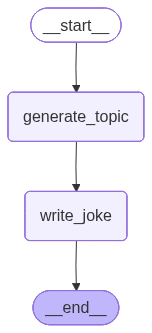

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 第一步: 正常使用 graph.invoke 执行一遍流程
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

Try: “An overly honest GPS that judges your life choices.”  
Premise idea: it not only gives directions but also passive‑aggressive life advice — “In 200 feet, turn left. Also maybe don’t text your ex again.”

"In 200 feet, turn left. Also, do not text your ex — and no, muting me won't make your life choices any better."


In [30]:
# 注意: get_state_history 是倒序的
states = list(graph.get_state_history(config))
for state in states:
    print(state.next)  # 下一个执行节点
    print(state.config["configurable"]["checkpoint_id"])  # 当前的 checkpoint_id
    print()

()
1f0aa5e5-b560-6caa-8002-b32bb6d2898f

('write_joke',)
1f0aa5e5-69bd-6a96-8001-c024d6fa7c28

('generate_topic',)
1f0aa5e5-2dbe-65ce-8000-e48fa59efa26

('__start__',)
1f0aa5e5-2dba-6e22-bfff-f58653808274



In [ ]:
# 第二步: 选择需要回溯的位置
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)
print(selected_state.config)

('write_joke',)
{'topic': 'Try: “An overly honest GPS that judges your life choices.”  \nPremise idea: it not only gives directions but also passive‑aggressive life advice — “In 200 feet, turn left. Also maybe don’t text your ex again.”'}
{'configurable': {'thread_id': '05139e09-dd67-4473-8539-fe414e979853', 'checkpoint_ns': '', 'checkpoint_id': '1f0aa5e5-69bd-6a96-8001-c024d6fa7c28'}}


In [ ]:
# 第三步: 更新 state
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
# 注意 new_config 的 thread_id 没变, 但 checkpoint_id 发生了变化
print(new_config)

{'configurable': {'thread_id': '05139e09-dd67-4473-8539-fe414e979853', 'checkpoint_ns': '', 'checkpoint_id': '1f0aa5e5-de02-6739-8002-3244e418e968'}}


In [33]:
# 第四步: 从回溯位置继续执行
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken join a band? Because it already had the drumsticks.'}

In [35]:
config

{'configurable': {'thread_id': UUID('05139e09-dd67-4473-8539-fe414e979853')}}

In [34]:
new_config

{'configurable': {'thread_id': '05139e09-dd67-4473-8539-fe414e979853',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0aa5e5-de02-6739-8002-3244e418e968'}}

In [ ]:
# 看起来实际上在同一个 thread 内继续往后追加 checkpoint, 并非创建分支
for state in graph.get_state_history(config):
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0aa5ec-ade6-6f1b-8003-dd88e5b8ee2c

('write_joke',)
1f0aa5e5-de02-6739-8002-3244e418e968

()
1f0aa5e5-b560-6caa-8002-b32bb6d2898f

('write_joke',)
1f0aa5e5-69bd-6a96-8001-c024d6fa7c28

('generate_topic',)
1f0aa5e5-2dbe-65ce-8000-e48fa59efa26

('__start__',)
1f0aa5e5-2dba-6e22-bfff-f58653808274



# Part 3: 用 LangGraph 搭建一些实际的 Agent

(1) 实际项目中的 workflow

(2) react agent / tool call agent: 如果大家都清楚就先跳过 tool_call_basic.py, 直接进入 prebuild 以及用 langgraph 基本组件来实现

(3) python 解释器 (smolagent)

(4) plan-and-execute (llm-compiler 可能考虑放弃, 只讲大概)

## 3.1 实际项目中的 workflow

TODO

## 3.2 langgraph 实现 tool call agent

- 原生 HTTP 接口实现: [examples/tool_use_basic/tool_use_basic.py](examples/tool_use_basic/tool_use_basic.py)
- langgraph 手工实现: [examples/tool_use_langgraph/graph.py](examples/tool_use_langgraph/graph.py)
- langgraph 内置实现的用法: 参考官方文档 [https://docs.langchain.com/oss/python/langchain/agents](https://docs.langchain.com/oss/python/langchain/agents)

3.3 见代码

3.4 见代码

# 4. 附录

**参考资料**

关于 langchain/langgraph 的官方文档 

(1) langgraph v0.x 文档 (位于 langgraph 项目里的文档)

(2) 目前官方将 langchain/langgraph/langsmith/langgraph studio 等文档放在一个统一的仓库进行维护

其他资料

(3) 官方课程

**一些扩展内容**

更 fancy 的一些 agent:

- browser use: 可以体验下 manus, 另外 open-manus 这个项目里的 broswer-use 工具可以看具体的实现方式 (备注: open-manus 和 manus 还是有比较大的差距, 不可同日而语)
- canvas: 写作助手, 本质上是比较简单的 workflow, 配合上前端交互
- ADK: google 开发的全代码模式框架, 算是跟 langchain/langgraph 类似的框架, 在它的语境里, Agent 节点被定义为了 LLM + sub_agents + tools. 各个 Agent 节点形成树状结构, 每个 Agent 可以选择 直接回答/使用工具/转交给其父,子,兄弟Agent 来解决问题

其他代码模式开发 Agent 的通用框架

- ADK: 个人感觉其 workflow 相关组件在组装是不像 langgraph 那种图状结构
- guidance/??: 基于模板语法来实现工作流, 基本上算是专为这类 `llm + 固定程序` 发明了完整的"语言"

langgraph 更深入的一些内容:

- memory: https://langchain-ai.github.io/langgraph/concepts/memory/
除了 thread 维度的 memory, 其实还有 user 维度的 memory, 除了 in-memory 的存储方式, 还有 Postgres, MangoDB, Redis 这种数据库类能持续存储, 用于生产环境
- Functional API
- Pregel
- 节点并行注意事项
- ...

# 以下为草稿, 后续整合或删除

prebuild react agent

In [21]:
def get_weather(city: str) -> str:  
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# agent = create_react_agent(
#     model=model,  
#     tools=[get_weather],  
#     prompt="You are a helpful assistant"  
# )

agent = create_agent(
    model=model,  
    tools=[get_weather],  
    system_prompt="You are a helpful assistant"  
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='1a6686b1-fded-4d0e-9fae-ba9f3d645543'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 140, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CQ41jrZLzdpf6dQpv4pYEfvh7BINV', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--89e6ca4a-8b2e-4e5f-9376-c2417b8dd669-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'San Francisco'}, 'id': 'call_tpozgacjWcU6kJnBfFPK0nRN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 140, 'output_tokens': 89, 'total_tokens': 22

并行的陷阱

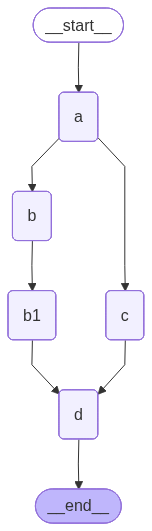

In [ ]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    # state: Annotated[list, operator.add]
    state: Annotated[list, sorting_reducer]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}


builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b1")
builder.add_edge("b1", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for event in graph.invoke({"state": []}, stream_mode=["values"]):
    print(event)

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B1 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B1", "I'm C", "I'm D"]
('values', {'state': []})
('values', {'state': ["I'm A"]})
('values', {'state': ["I'm A", "I'm B", "I'm C"]})
('values', {'state': ["I'm A", "I'm B", "I'm B1", "I'm C", "I'm D"]})
('values', {'state': ["I'm A", "I'm B", "I'm B1", "I'm C", "I'm D", "I'm D"]})


ToolNode (单独模块)

In [ ]:
@lc_tool
def operator_add(a: int, b: int) -> int:
    """add two intergers"""
    return a + b

operator_add.invoke({"a": 1, "b": 2})

3

In [30]:
tool_node = ToolNode([operator_add])

/tmp/ipykernel_1944/3091856797.py:1: LangGraphDeprecatedSinceV10: ToolNode has been moved to langchain.agents.tool_node. Please update your import to 'from langchain.agents.tool_node import ToolNode'. Deprecated in LangGraph V1.0 to be removed in V2.0.
  tool_node = ToolNode([operator_add])


In [36]:
msg = AIMessage(
    content="",
    tool_calls=[
        {
            "id": "call_1",
            "name": "operator_add",
            "args": {"a": 1, "b": 2}
        }
    ]
)

tool_node.invoke(
    # {"messages": [msg]}
    {"messages": [msg], "x": 1}
    # [msg]
)

{'messages': [ToolMessage(content='3', name='operator_add', tool_call_id='call_1')]}

In [33]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    x: str

builder = StateGraph(State)
builder.add_node("tool_node", tool_node)
builder.add_edge(START, "tool_node")
builder.add_edge("tool_node", END)
app = builder.compile()
app.invoke(
    {
        "messages": [msg]
    }
)

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='a75ce83d-da81-489c-82cc-41800dbcbd46', tool_calls=[{'name': 'operator_add', 'args': {'a': 1, 'b': 2}, 'id': 'call_1', 'type': 'tool_call'}]),
  ToolMessage(content='3', name='operator_add', id='42cb8356-9d13-4249-aa63-6c44393be27f', tool_call_id='call_1')]}

In [ ]:
from pydantic import BaseModel, Field

class ExecuteCode(BaseModel):
    """The input to the numexpr.evaluate() function."""

    reasoning: str = Field(
        ...,
        description="The reasoning behind the code expression, including how context is included, if applicable.",
    )

    code: str = Field(
        ...,
        description="The simple code expression to execute by numexpr.evaluate().",
    )

llm = model.with_structured_output(
    ExecuteCode, method="function_calling"
)

# 本质上是先将大模型先 bind 一个必须调用的 function call, 然后将 tool_call 转化为 Pydantic BaseModel
from langchain_core.output_parsers.openai_tools import PydanticToolsParser

In [ ]:
llm

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7d1c7a33d100>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d1c797b0980>, root_client=<openai.OpenAI object at 0x7d1c7a33d8e0>, root_async_client=<openai.AsyncOpenAI object at 0x7d1c7a33e990>, model_name='gpt-5-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://api.gptsapi.net/v1'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'ExecuteCode', 'description': 'The input to the numexpr.evaluate() function.', 'parameters': {'properties': {'reasoning': {'description': 'The reasoning behind the code expression, including how context is included, if applicable.', 'type': 'string'}, 'code': {'description': 'The simple code expression to execute by numexpr.evaluate().', 'type': 'string'}}, 'required': ['reasoning', 'code'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'m

In [53]:
llm.invoke([{"role": "user", "content": "34 * 38 = ?"}])

ExecuteCode(reasoning='Compute the product of 34 and 38 using a simple arithmetic expression.', code='34 * 38')

In [42]:
msg = llm.first.invoke([{"role": "user", "content": "34 * 38 = ?"}])

In [52]:
msg.tool_calls

[{'name': 'ExecuteCode',
  'args': {'reasoning': 'Compute product of 34 and 38 directly using arithmetic.',
   'code': '34*38'},
  'id': 'call_3AEKHb2iewotLlBsRjpxrEIX',
  'type': 'tool_call'}]

In [51]:
llm.last.invoke(msg)

ExecuteCode(reasoning='Compute product of 34 and 38 directly using arithmetic.', code='34*38')

In [56]:
import numexpr
str(numexpr.evaluate("1+4"))

'5'

In [58]:
from examples.llm_compiler.math_tools import get_math_tool

In [60]:
math_tool = get_math_tool(model)
math_tool.invoke(
    {
        "problem": "What's the temp of sf + 5?",
        "context": ["Thet empreature of sf is 32 degrees"],
    }
)

'37'

In [66]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
prompt = client.pull_prompt("wfh/llm-compiler")

In [68]:
prompt.pretty_print()

================================ System Message ================================

Given a user query, create a plan to solve it with the utmost parallelizability. Each plan should comprise an action from the following {num_tools} types:
{tool_descriptions}
{num_tools}. join(): Collects and combines results from prior actions.

 - An LLM agent is called upon invoking join() to either finalize the user query or wait until the plans are executed.
 - join should always be the last action in the plan, and will be called in two scenarios:
   (a) if the answer can be determined by gathering the outputs from tasks to generate the final response.
   (b) if the answer cannot be determined in the planning phase before you execute the plans. Guidelines:
 - Each action described above contains input/output types and description.
    - You must strictly adhere to the input and output types for each action.
    - The action descriptions contain the guidelines. You MUST strictly follow those guideline

Inject State

此概念来自之前看的一个 B 站视频里提及

https://python.langchain.com/docs/concepts/tools/?utm_source=chatgpt.com#special-type-annotations